<a href="https://colab.research.google.com/github/LorenzoMauri/Advanced-Machine-Learning/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Advanced Machine Learning</center></h1> 


---


<h3><center>Assignment 1</center></h3> 
<h6><center>Lorenzo Mauri matr. 807306</center></h6> 

---


 

* Importazione librerie e dati 

In [55]:
#!apt update
#!apt install python3-rtree 
#!pip install git+git://github.com/geopandas/geopandas.git

In [56]:
import os 
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statistics 
from sklearn.model_selection import train_test_split
import numpy
import shapely
import geopandas as gdp
from shapely.geometry import Point,Polygon
from tensorflow import keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 


In [57]:
os.chdir('/content/drive/My Drive/Advanced Machine Learning /assignment1/data')
test_set=pd.read_csv('X_test.csv').iloc[:, 1:]
x_train=pd.read_csv('X_train.csv').iloc[:, 1:]
y_train=pd.read_csv('y_train.csv').iloc[:, 1:]

df = x_train.copy() 
df['y'] = y_train 

In [58]:
#model = keras.models.load_model('neural_network')




---


<h1><center>Analisi esplorativa</center></h1>


---



In [59]:
print(test_set[['latitude','longitude']].min())
df[['latitude','longitude']].max()

latitude        40.50708
longitude   -74124.00000
dtype: float64


latitude     40894.00000
longitude      -73.71299
dtype: float64

In [60]:
def unbias(row):
  if abs(row) > 1000 :
    return row/1000.0
  else : return row

df['latitude']=df['latitude'].apply(unbias)
df['longitude']=df['longitude'].apply(unbias)

In [61]:
gdf = gdp.GeoDataFrame(df, 
                       geometry=gdp.points_from_xy(df.longitude, df.latitude),
                       crs=4326)
gdf.geometry = gdf.geometry.to_crs({'init': 'epsg:2263'})

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [62]:
boroughs = gdp.read_file(gdp.datasets.get_path("nybb"))
boroughs=boroughs.to_crs(epsg=2263)

In [63]:
data = gdp.sjoin(right_df=boroughs[['BoroName','geometry']],
                 left_df=gdf,how="left",op="intersects")
data.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,y,geometry,index_right,BoroName
0,40.71239,-73.95271,4,2,0.19,1,0,1,0,65,POINT (997360.173 198822.927),2.0,Brooklyn
1,40.69600,-73.91303,4,17,0.66,2,307,1,0,57,POINT (1008366.557 192859.992),2.0,Brooklyn
2,40.62707,-74.02817,3,1,0.04,1,87,0,0,225,POINT (976430.455 167736.146),2.0,Brooklyn
3,40.77910,-73.98565,1,4,0.08,1,0,0,1,175,POINT (988224.259 223124.302),3.0,Manhattan
4,40.75777,-73.93509,1,0,0.00,1,358,1,0,125,POINT (1002232.701 215359.412),1.0,Queens


* Rimozione degli outlier

> sfrutto il range interquartile della variabile `price` per determinare gli outlier

$$
IQR = Q_3-Q_1
$$

>Condizione : l'osservazione $x$ è un outlier se 

$$
x < Q_1 - \frac{3}{2} IQR  
$$

<h5><center>oppure</center></h5> 


$$
x > Q_3 +  \frac{3}{2} IQR  
$$








In [64]:
iqr = data.y.quantile(q=.75)-data.y.quantile(q=.25)
upper = data.y.quantile(q=.75)+(1.5*iqr) 
lower = data.y.quantile(q=.25)-(1.5*iqr) 
df = data[(data['y']>0) & (data['y']<upper)]

In [65]:
def label_pricing(x):
  if x <= 117.67:
    return 'low'
  if x > 117.67 and x <= 235.33 :
    return 'medium' 
  if x > 235.33 : return 'high'

df['pricing']=df.y.apply(label_pricing)
data['pricing']=data.y.apply(label_pricing)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:1109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


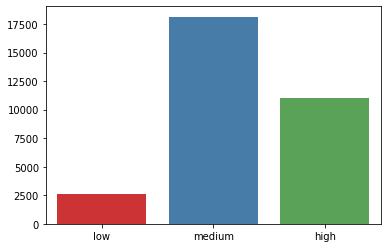

In [86]:
sns.barplot(x=['low','medium','high'],y=list(df.groupby(by='pricing').size()),palette='Set1')

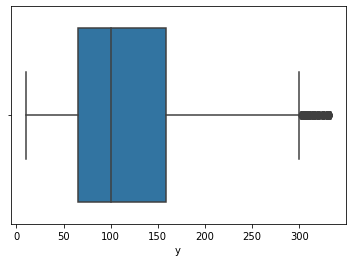

In [68]:
sns.boxplot(x=df.y)

In [69]:
data=df.copy()
data_selected =  data[['y','minimum_nights', 'number_of_reviews','reviews_per_month','calculated_host_listings_count',
'availability_365', 'Private_room', 'Entire_home/apt','BoroName']]
data_selected = data_selected.dropna()
data_selected = data_selected.reset_index()



---

<h1><center>Encoding coordinate geografiche</center></h1> 



---




In [70]:
columnTransformer = ColumnTransformer([('encoder', 
                                        OneHotEncoder(), 
                                        [-1])], 
                                      remainder='passthrough') 
  
data_encoded = columnTransformer.fit_transform(data_selected)

data_encoded = pd.DataFrame(data_encoded)
one_hot_encoding=data_encoded.iloc[:,0:5]
one_hot_encoding.head()

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [71]:
data_selected_encoded = data_selected.join(one_hot_encoding)
data_selected_encoded=data_selected_encoded.drop(columns=['BoroName'])
data_selected_encoded1=data_selected_encoded.iloc[:,1:]
data_selected_encoded1.head()

,y,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,0,1,2,3,4
0,65,4,2,0.19,1,0,1,0,0.0,1.0,0.0,0.0,0.0
1,57,4,17,0.66,2,307,1,0,0.0,1.0,0.0,0.0,0.0
2,225,3,1,0.04,1,87,0,0,0.0,1.0,0.0,0.0,0.0
3,175,1,4,0.08,1,0,0,1,0.0,0.0,1.0,0.0,0.0
4,125,1,0,0.00,1,358,1,0,0.0,0.0,0.0,1.0,0.0


In [72]:
data_selected_encoded1 = data_selected_encoded1[data_selected_encoded1['y']!=0]



---

<h1><center>Normalizzazione</center></h1> 



---



In [73]:
def normalizzazione(x):
  min=numpy.min(x)
  max = numpy.max(x)
  return (x-min)/(max-min)
  
df_normalized = data_selected_encoded1.apply(normalizzazione,axis=0)
minY = numpy.min(data_selected_encoded1.y)
maxY = numpy.max(data_selected_encoded1.y)

In [74]:
df_normalized.head()

,y,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,0,1,2,3,4
0,0.170279,0.003006,0.003180,0.003248,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.145511,0.003006,0.027027,0.011282,0.003067,0.841096,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.665635,0.002004,0.001590,0.000684,0.000000,0.238356,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.510836,0.000000,0.006359,0.001368,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.356037,0.000000,0.000000,0.000000,0.000000,0.980822,1.0,0.0,0.0,0.0,0.0,1.0,0.0




---



<h1><center>Data Modelling</center></h1> 



---



In [75]:
df_to_split=df_normalized.copy()
x_train, x_test, y_train, y_test = train_test_split(df_to_split.iloc[:,1:], df_to_split.iloc[:,0], test_size=0.1,random_state=28102020)

In [76]:
hidden_units = 32
activation='relu'
batch=32
valmin_weights=-0.03
valmax_weights=0.03
model = Sequential()
model.add(Dense(units =12,
                input_dim=12,
                activation= activation,
                kernel_initializer = keras.initializers.RandomUniform(minval=valmin_weights, maxval=valmax_weights, seed=None),
                bias_initializer='zero'))
  
model.add(Dense(units = hidden_units,
                activation=activation,
                kernel_initializer =  keras.initializers.RandomUniform(minval=valmin_weights, maxval=valmax_weights, seed=None),
                bias_initializer='zero'))

model.add(Dense(units = 1,activation=activation))   
opt = keras.optimizers.Adam(learning_rate=0.001,decay = 0.01)
model.compile(loss='mean_squared_error', optimizer= opt, metrics=[keras.metrics.RootMeanSquaredError()])
modello = model.fit(x_train, y_train, epochs=30,validation_data=(x_test,y_test),batch_size = batch )

Epoch 1/30
894/894 [==============================] - 1s 1ms/step - loss: 0.0291 - root_mean_squared_error: 0.1707 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 2/30
894/894 [==============================] - 1s 1ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1532
Epoch 3/30
894/894 [==============================] - 1s 1ms/step - loss: 0.0240 - root_mean_squared_error: 0.1551 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1530
Epoch 4/30
894/894 [==============================] - 1s 992us/step - loss: 0.0240 - root_mean_squared_error: 0.1548 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1528
Epoch 5/30
894/894 [==============================] - 1s 988us/step - loss: 0.0239 - root_mean_squared_error: 0.1547 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 6/30
894/894 [==============================] - 1s 981us/step - loss: 0.0239 - root_mean_squared_error: 0.1546 - val_loss: 0.0233 

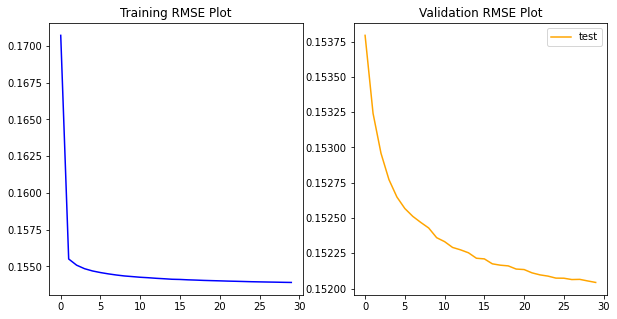

In [77]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(modello.history['root_mean_squared_error'],label='training',color='blue')
plt.title('Training RMSE Plot')
plt.subplot(1,2,2)
plt.plot(modello.history['val_root_mean_squared_error'],label='test',color='orange')
plt.title('Validation RMSE Plot')
plt.legend()
plt.show()

In [78]:
a = model.predict(x_test)
a=[i[0] for i in a.tolist()]
mediaY= numpy.mean(data_selected_encoded1.y)
stdY = numpy.std(data_selected_encoded1.y)
predicted_scaled = pd.DataFrame(a)
actual = pd.DataFrame(y_test)
test = pd.DataFrame({'actual_scaled':y_test.to_list(),'predicted_scaled':a})
diff = maxY-minY
test['predicted']=test['predicted_scaled'].apply(lambda x : (x*diff)+minY)
test['actual']=test['actual_scaled'].apply(lambda x : (x*diff)+minY)
test['MAE']=abs(test.predicted-test.actual)
test['RMSE'] = (test.predicted-test.actual)**2
print(f"MAE : {round(sklearn.metrics.mean_absolute_error(y_true=test.actual,y_pred=test.predicted),3)}")
print(f"RMSE : {round(math.sqrt(sklearn.metrics.mean_squared_error(y_true=test.actual,y_pred=test.predicted)),3)}")
test.head()

MAE : 36.164
RMSE : 49.11


,actual_scaled,predicted_scaled,predicted,actual,MAE,RMSE
0,0.216718,0.256812,92.950163,80.0,12.950163,167.706709
1,0.588235,0.515502,176.507061,200.0,23.492939,551.918171
2,0.402477,0.414495,143.881747,140.0,3.881747,15.067963
3,0.433437,0.564050,192.188214,150.0,42.188214,1779.845386
4,0.743034,0.447307,154.480245,250.0,95.519755,9124.023670













---


* ripeto le stesse operazioni sul test set fornito in modo tale da poter ottenere le previsioni

In [81]:
def geo_coordinates_transformer(df):
  df['latitude']=df['latitude'].apply(unbias)
  df['longitude']=df['longitude'].apply(unbias)
  gdf = gdp.GeoDataFrame(
  df, geometry=gdp.points_from_xy(df.longitude, df.latitude),crs=4326)
  gdf.geometry = gdf.geometry.to_crs({'init': 'epsg:2263'})
  boroughs = gdp.read_file(gdp.datasets.get_path("nybb"))
  boroughs=boroughs.to_crs(epsg=2263)
  data = gdp.sjoin(right_df=boroughs[['BoroName','geometry']],
                 left_df=gdf,            how="left",                 op="intersects")
  data_selected =  data[['minimum_nights', 'number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365',
                         'Private_room', 'Entire_home/apt','BoroName']]
  data_selected = data_selected.dropna()
  data_selected = data_selected.reset_index()
  columnTransformer = ColumnTransformer([('encoder', 
                                        OneHotEncoder(), 
                                        [-1])], 
                                      remainder='passthrough') 
  
  data_encoded = columnTransformer.fit_transform(data_selected)

  data_encoded = pd.DataFrame(data_encoded)
  one_hot_encoding=data_encoded.iloc[:,0:5]
  data_selected_encoded = data_selected.join(one_hot_encoding)
  data_selected_encoded=data_selected_encoded.drop(columns=['BoroName'])
  data_selected_encoded1=data_selected_encoded.iloc[:,1:]
  df_normalized = data_selected_encoded1.apply(normalizzazione,axis=0)
  return df_normalized


In [82]:
test_set=pd.read_csv('X_test.csv').iloc[:, 1:]
test_set_normalized = geo_coordinates_transformer(test_set)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))




---
<h1><center>Risultati</center></h1> 


---



In [89]:
predictions = model.predict(test_set_normalized)
predictions=[i[0] for i in predictions.tolist()]
df_predictions = pd.DataFrame([(i*stdY)+mediaY for i in a ])
df_predictions

,0
0,137.203740
1,154.772366
2,147.912586
3,158.069476
4,150.141020
...,...
3172,131.693617
3173,147.949967
3174,155.817565
3175,159.980226


In [91]:
#df_predictions.to_csv("Lorenzo_Mauri_807306_score1.txt",header = False, index=False ) 